In [4]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
from google.protobuf.json_format import MessageToDict

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from IPython.display import Image, HTML, clear_output



def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


Num GPUs Available:  1


In [4]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 4
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [5]:
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)


def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  6272      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2064      
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


In [8]:
TARGET_SIZE=40

def load_emoji(emoji,max_size=TARGET_SIZE):
  #gotem this just loads a picture of mario now lmao
  img = plt.imread("Mario.png")
  img = np.float32(img)
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

target_img = load_emoji(0)
print(target_img.shape)
plt.imshow(zoom(to_rgb(target_img), 2), fmt='png')


(40, 40, 4)


NameError: name 'zoom' is not defined

In [7]:
#This pool class isnt super necessary

#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


In [8]:
#@title Initialize Training { vertical-output: true}

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file train_log already exists.
Error occurred while processing: train_log.


batch (before/after):


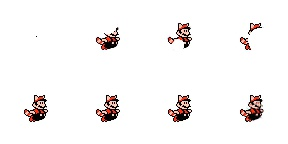

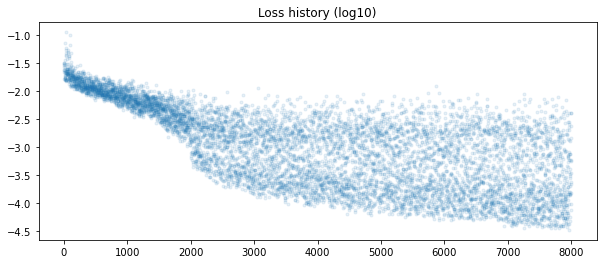

 step: 8001, log10(loss): -3.242

In [9]:
#@title Training Loop {vertical-output: true}

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(8000+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    x0[:1] = seed
    if DAMAGE_N:
      damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
      x0[-DAMAGE_N:] *= damage
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
  
  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    visualize_batch(x0, x, step_i)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [14]:
import IPython
last_checkpoint_fn = sorted(glob.glob('train_log/*.json'))[-1]
model_str = open(last_checkpoint_fn).read()

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model_str)

print(data_js)


  window.GRAPH_URL = URL.createObjectURL(new Blob([`{"format": "graph-model", "modelTopology": {"node": [{"name": "x", "op": "Placeholder", "attr": {"shape": {"shape": {"dim": [{"size": "-1"}, {"size": "-1"}, {"size": "-1"}, {"size": "16"}]}}, "dtype": {"type": "DT_FLOAT"}}}, {"name": "step_size", "op": "Placeholder", "attr": {"shape": {"shape": {}}, "dtype": {"type": "DT_FLOAT"}}}, {"name": "angle", "op": "Placeholder", "attr": {"shape": {"shape": {}}, "dtype": {"type": "DT_FLOAT"}}}, {"name": "fire_rate", "op": "Placeholder", "attr": {"shape": {"shape": {}}, "dtype": {"type": "DT_FLOAT"}}}, {"name": "strided_slice/stack", "op": "Const", "attr": {"value": {"tensor": {"dtype": "DT_INT32", "tensorShape": {"dim": [{"size": "4"}]}, "tensorContent": "AAAAAAAAAAAAAAAAAwAAAA=="}}, "dtype": {"type": "DT_INT32"}}}, {"name": "strided_slice/stack_1", "op": "Const", "attr": {"value": {"tensor": {"dtype": "DT_INT32", "tensorShape": {"dim": [{"size": "4"}]}, "tensorContent": "AAAAAAAAAAAAAAAABAAAA

In [18]:
ca.weights

[<tf.Variable 'sequential_5/conv2d_10/kernel:0' shape=(1, 1, 48, 128) dtype=float32, numpy=
 array([[[[ 0.16306189, -0.17672028, -0.1712502 , ...,  0.08990008,
            0.051592  , -0.05352798],
          [-0.09778561, -0.05817322,  0.01879469, ..., -0.06235752,
            0.09487447, -0.20466131],
          [ 0.1399991 ,  0.03273897,  0.30812186, ...,  0.23715378,
           -0.07023945,  0.10489243],
          ...,
          [-0.02151174, -0.21489763, -0.23701741, ..., -0.06646769,
           -0.04433715, -0.02596584],
          [-0.07356378, -0.40414712,  0.18517171, ...,  0.21828982,
            0.15019742,  0.02894769],
          [-0.01749169,  0.19913672, -0.15900862, ..., -0.2218723 ,
            0.0805899 ,  0.09259932]]]], dtype=float32)>,
 <tf.Variable 'sequential_5/conv2d_10/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 0.0087548 ,  0.00175629, -0.02807511, -0.01867815, -0.05347456,
        -0.04602627, -0.01918833, -0.01860187,  0.0307787 , -0.09167819,
        -0

In [20]:
1*1*48*128+128*16+16+128

8336